# Apply AI Superresolution to selected images




# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "MWCNNV2"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution test on images.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution test on images.ipynb
/media/SSD/superres/Results/Superresolution test on images


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)


/media/SSD/superres/checkpoint


In [6]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage,Normalize

from torchvision.transforms.functional import hflip

import random

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [7]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers

torch.cuda.manual_seed(42)

# MWCNN

In [8]:
import common
import torch.nn as nn

def rgb_to_grayscale(img, num_output_channels = 1):
    

    r, g, b = img.unbind(dim=-3)
    # This implementation closely follows the TF one:
    # https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/ops/image_ops_impl.py#L2105-L2138
    l_img = (0.2989 * r + 0.587 * g + 0.114 * b).to(img.dtype)
    l_img = l_img.unsqueeze(dim=-3)

    if num_output_channels == 3:
        return l_img.expand(img.shape)

    return l_img

class MWCNN(nn.Module):
    def __init__(self, n_feats, nColor , conv=common.default_conv):
        super(MWCNN, self).__init__()
        kernel_size = 3
        self.scale_idx = 0

        act = nn.ReLU(True)

        self.DWT = common.DWT()
        self.IWT = common.IWT()

        n = 1
        m_head = [common.BBlock(conv, nColor, n_feats, kernel_size, act=act)]
        d_l0 = []
        d_l0.append(common.DBlock_com1(conv, n_feats, n_feats, kernel_size, act=act, bn=False))


        d_l1 = [common.BBlock(conv, n_feats * 4, n_feats * 2, kernel_size, act=act, bn=False)]
        d_l1.append(common.DBlock_com1(conv, n_feats * 2, n_feats * 2, kernel_size, act=act, bn=False))

        d_l2 = []
        d_l2.append(common.BBlock(conv, n_feats * 8, n_feats * 4, kernel_size, act=act, bn=False))
        d_l2.append(common.DBlock_com1(conv, n_feats * 4, n_feats * 4, kernel_size, act=act, bn=False))
        pro_l3 = []
        pro_l3.append(common.BBlock(conv, n_feats * 16, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(common.DBlock_com(conv, n_feats * 8, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(common.DBlock_inv(conv, n_feats * 8, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(common.BBlock(conv, n_feats * 8, n_feats * 16, kernel_size, act=act, bn=False))

        i_l2 = [common.DBlock_inv1(conv, n_feats * 4, n_feats * 4, kernel_size, act=act, bn=False)]
        i_l2.append(common.BBlock(conv, n_feats * 4, n_feats * 8, kernel_size, act=act, bn=False))

        i_l1 = [common.DBlock_inv1(conv, n_feats * 2, n_feats * 2, kernel_size, act=act, bn=False)]
        i_l1.append(common.BBlock(conv, n_feats * 2, n_feats * 4, kernel_size, act=act, bn=False))

        i_l0 = [common.DBlock_inv1(conv, n_feats, n_feats, kernel_size, act=act, bn=False)]

        m_tail = [conv(n_feats, nColor, kernel_size)]

        self.head = nn.Sequential(*m_head)
        self.d_l2 = nn.Sequential(*d_l2)
        self.d_l1 = nn.Sequential(*d_l1)
        self.d_l0 = nn.Sequential(*d_l0)
        self.pro_l3 = nn.Sequential(*pro_l3)
        self.i_l2 = nn.Sequential(*i_l2)
        self.i_l1 = nn.Sequential(*i_l1)
        self.i_l0 = nn.Sequential(*i_l0)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        x = rgb_to_grayscale(x)
        x0 = self.d_l0(self.head(x))
        x1 = self.d_l1(self.DWT(x0))
        x2 = self.d_l2(self.DWT(x1))
        x_ = self.IWT(self.pro_l3(self.DWT(x2))) + x2
        x_ = self.IWT(self.i_l2(x_)) + x1
        x_ = self.IWT(self.i_l1(x_)) + x0
        x = self.tail(self.i_l0(x_)) + x

        return x

    def set_scale(self, scale_idx):
        self.scale_idx = scale_idx

In [9]:
#model = torch.load("/media/SSD/superres/checkpoint/MWCNNV2_epoch_48.pth")["model"]
model = torch.load("/media/SSD/superres/checkpoint/MWCNNV2_epoch_24.pth")["model"]


model.cuda()

MWCNN(
  (DWT): DWT()
  (IWT): IWT()
  (head): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (d_l2): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DBlock_com1(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (d_l1): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DBlock_com1(
      (body): Sequential(
        (0): Conv2d(128, 128,

In [10]:
mcombine = model

## Convert images

In [11]:
from torch.cuda.amp import autocast

In [12]:
def cv2_to_batch_tensor(img_bgr):
    mn=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    im_rgb = im_rgb/255.0
    im_rgb = (im_rgb-mn)/std
    tform = im_rgb.transpose(( 2,0, 1))
    tform = torch.from_numpy(tform).float()
    tform = tform.unsqueeze(0)
    return tform

def batch_tensor_to_cv2(bt_3ch):
    bt_3ch = (bt_3ch*255.0).clamp(0,255)
    t_3ch = bt_3ch.squeeze(0)
    #t_3ch = t_3ch.cpu()
    im_rbg = t_3ch.permute(1,2,0).numpy().astype(np.uint8)
    im_bgr = cv2.cvtColor(im_rbg, cv2.COLOR_RGB2BGR)
    
    return im_bgr

def gs_batch_tensor_to_bgr_cv2(bt_1ch, frame):
    ##convert greyscale batch tensor to bgr cv2
    
    bt_1ch = (bt_1ch*255.0).clamp(0,255)
    t_1ch = bt_1ch.squeeze(0)
    #t_3ch = t_3ch.cpu()
    im_h_y = t_1ch.numpy().astype(np.float32)
    
    im_y, im_b_ycbcr = decolorize_cv(frame) 
    
    im_h_y = im_h_y[0,:,:]

    im_h = colorize_cv(im_h_y, im_b_ycbcr)
    
    return im_h


In [13]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop
def superres_image(img_cv,model,factor=1.0,center_crop=None):


    

    if center_crop is None:
        width  = img_cv.shape[1]
        height = img_cv.shape[0]
        
    else:
        width,height = center_crop
    
    
    success_flag = False
    
    print("Original:")
    print("width=",width,"\nheight=",height)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcessed:")
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height)
    
   
            
    #crop img_cv if needed
    if center_crop is not None:
        img_cv = cv_center_crop(img_cv,(height,width))

    if (factor != 1.0):
        img_cv = cv2.resize(img_cv, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

    im_input = cv2_to_batch_tensor(img_cv)


    im_input = im_input.cuda()


    with torch.no_grad():
        with autocast():
            mout = model(im_input)  


    out=mout.cpu()



    im_h = batch_tensor_to_cv2(out)
    ##convert from greyscale to color
    im_h = gs_batch_tensor_to_bgr_cv2(out,img_cv)


    return im_h

In [14]:
path = "/media/SSD/samba/users/Julie1200dpi8bit001.jpg"

In [33]:

img = cv2.imread(path)
# convert to PIL RGB
img = cv2.fastNlMeansDenoisingColored(img,None,15,10,7,21)

im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    

In [34]:
im_rgb.shape[0], im_rgb.shape[1]

(3264, 4287)

In [35]:
im_rgb = cv_center_crop(im_rgb,(3200,4000))

In [36]:
fact=.1

In [37]:
im_rgb = cv2.resize(im_rgb, (int(4000*fact),int(3200*fact)), interpolation=cv2.INTER_LANCZOS4)

In [38]:
res_image = superres_image(img_cv=im_rgb,model=mcombine,factor=1,center_crop=None)

Original:
width= 400 
height= 320

Processed:
factor: 1 
width= 400 
height= 320


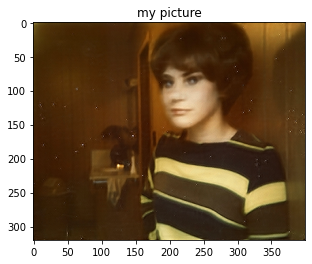

In [39]:
plt.imshow(res_image)
plt.title('my picture')
plt.show()

In [40]:
cv2.imwrite("/media/SSD/samba/users/Julie1200dpi8bit001_scaled_enhanced.jpg", cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB))

True

In [41]:
cv2.imwrite("/media/SSD/samba/users/Julie1200dpi8bit001_scaled.jpg", cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB))

True

# Second approach

In [ ]:
import torch.nn as nn
class NEWNet6(nn.Module):
    def __init__(self, c1, c2, c3):
        super(NEWNet6, self).__init__()   
        
        self.p1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU()
        )
        
        self.p2 = nn.Sequential(
            nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=1, stride=1, padding=0, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c1, kernel_size=1, stride=1, padding=0, bias=True)
        )
        
        self.p3 = nn.Sequential(
            nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=1, stride=1, padding=0, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c1, kernel_size=1, stride=1, padding=0, bias=True)
        
        
        )

        
        self.prelu = nn.PReLU()
        self.convf = nn.Conv2d(in_channels=c1, out_channels=3, kernel_size=3, stride=1, padding=1, bias=True)
        
                    
        
        
    def forward(self, x0,xm1,xp1, k):    
        
        residual = x0
       
        # add insert k as the 10 channel into x, which has 9 channels
        one_channel = x0[:,0,:,:].unsqueeze(1)  #use one channel as a template
        t1 = torch.ones_like(one_channel.permute(3,2,1,0))  #make a ones tensor like the channel
        res = k[:,0]*t1  # multiply by k, so that the batch spreads to the size of an image
        res = res.permute(3,2,1,0) # put back in proper order
        xk = torch.cat((x0,xm1,xp1,res), dim=1) #append the 10th channel
        
        
        
        
        xk = self.p1(xk)
        skip1 = xk
                        
        xk = self.p2(xk)
        xk = xk.add_(skip1)
        skip2 = xk
        
        xk = self.p3(xk)
        xk = xk.add_(skip2)
        
        xk = self.prelu(xk)
        xk = self.convf(xk)
        out = torch.add(xk,residual)
        return out

In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN7_epoch_69.pth")["model"]
model = torch.load("/media/SSD/superres/checkpoint/NEWCNN7_epoch_81.pth")["model"]




#model = NEWNet6(c1=64,c2=128, c3=1024)
model.cuda()

In [ ]:
kmodel = torch.load("/media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_18.pth")["model"]

In [ ]:
kmodel.cuda()
kmodel.eval()

In [ ]:
class Combine_Nets(nn.Module):
    def __init__(self, model, kmodel):
        super(Combine_Nets, self).__init__()   
        
        
        self.model = model
        self.kmodel = kmodel
        
        

    def forward(self, x0, xm1, xp1):    
        
       
        k = self.kmodel(x0)
        #k=k*0+6.0
        x = self.model(x0, xm1, xp1,k)
        
        return x,k

In [ ]:
mcombine = Combine_Nets(model,kmodel)

In [ ]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop
def superres_image2(img_cv,model,factor=1.0,center_crop=None):


    

    if center_crop is None:
        width  = img_cv.shape[1]
        height = img_cv.shape[0]
        
    else:
        width,height = center_crop
    
    
    success_flag = False
    
    print("Original:")
    print("width=",width,"\nheight=",height)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcessed:")
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height)
    
   
            
    #crop img_cv if needed
    if center_crop is not None:
        img_cv = cv_center_crop(img_cv,(height,width))

    if (factor != 1.0):
        img_cv = cv2.resize(img_cv, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

    im_input = cv2_to_batch_tensor(img_cv)


    im_input = im_input.cuda()


    with torch.no_grad():
        with autocast():
            mout = model(im_input, im_input, im_input)  

                
    out=mout[0].cpu()



    im_h = batch_tensor_to_cv2(out)
    
    print("k=",mout[1].item())
    

    return im_h





In [ ]:
path = "/media/SSD/samba/users/Julie1200dpi8bit001.jpg"

In [ ]:

img = cv2.imread(path)
# convert to PIL RGB
img = cv2.fastNlMeansDenoisingColored(img,None,15,10,7,21)

    

In [ ]:
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
im_rgb.shape[0], im_rgb.shape[1]

In [ ]:
im_rgb = cv_center_crop(im_rgb,(3200,4000))

In [ ]:
fact=.5

In [ ]:
im_rgb = cv2.resize(im_rgb, (int(4000*fact),int(3200*fact)), interpolation=cv2.INTER_LANCZOS4)

In [ ]:
res_image = superres_image2(img_cv=im_rgb,model=mcombine,factor=1,center_crop=None)

In [ ]:
plt.imshow(res_image)
plt.title('my picture')
plt.show()

In [ ]:
cv2.imwrite("/media/SSD/samba/users/Julie1200dpi8bit001_scaled_enhanced.jpg", cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB))

In [ ]:
cv2.imwrite("/media/SSD/samba/users/Julie1200dpi8bit001_scaled.jpg", cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB))